In [1]:
!pip install requests -q

In [2]:
# importacao
import joblib
import pandas as pd
import os
import warnings
from pprint import pprint

In [3]:
features = [
#duas_classes_data_abs_texto_regu
{'X':'https://drive.google.com/file/d/1CJc7ASa5JUexh3sjifxZXpnvpNgrVVgM/view?usp=sharing','y':'https://drive.google.com/file/d/1APxDqaNiZ0SyNvDiabkEh2lnfXoYRU_8/view?usp=sharing'},
#tres_classes_data_abs_texto_recorr_lotes_regu
{'X':'https://drive.google.com/file/d/13GeI9wOhZGq-5_6vTA38ruSH8SqR0ALl/view?usp=sharing','y':'https://drive.google.com/file/d/1-sCT2s-_2JuSmrJHTwmXA_9lOyEwyxCn/view?usp=sharing'},
#quatro_classes_data_abs_texto_data_regu
{'X':'https://drive.google.com/file/d/1OBejRt2wVirTNOKIhkw3jdib0J7381Ce/view?usp=sharing','y':'https://drive.google.com/file/d/1MgnbEccN9NuYtuzLpLqPyWzsa-zupzTI/view?usp=sharing'}
]

In [4]:
dicleg=[['necessaria analise por servidor','necessario envio para definicao de politica / grupo especializado'],
        ['necessaria analise por servidor','necessario envio para definicao politica','necessario envio para grupo especializado'],
        ['automatizavel sem problemas','necessaria analise por servidor','necessario envio para definicao politica','necessario envio para grupo especializado']
        ]

In [5]:
indice_atual = 2

In [6]:
# Carrega o pre tratamento
urls = features[indice_atual]
cargas = {}
for key, url in urls.items():
    file_name =  url.split('/')[-2].split('?')[0]
    nurl ='https://drive.google.com/uc?id={file_id}&export=download'.format(file_id=file_name)
    cargas[key] = nurl

In [7]:
featture = features[indice_atual]

### Como acessar o arquivo de dados original.

In [8]:
# dados X e y Dataset
X = pd.read_csv(cargas['X'])
y = pd.read_csv(cargas['y'])

<Axes: xlabel='label'>

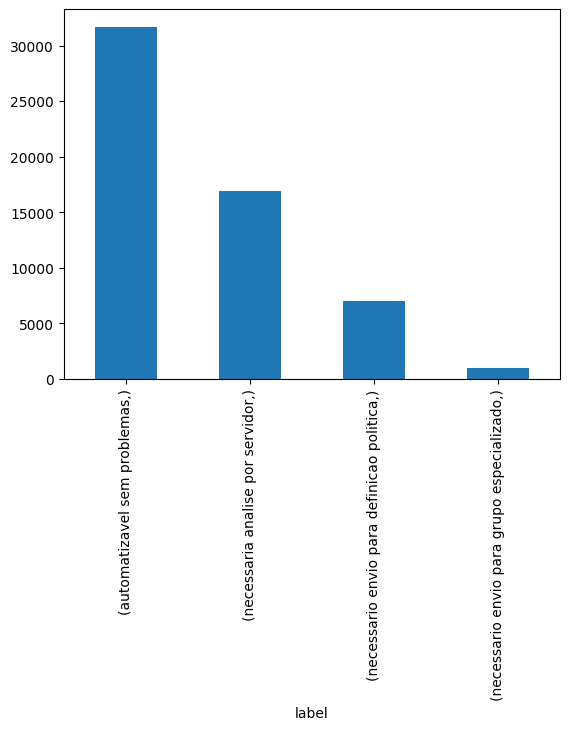

In [9]:
y.value_counts().plot(kind='bar')

In [10]:
dic_label = dicleg[indice_atual]
bin_label = [dicleg[2][0],'bypass']

In [11]:
# Importar bibliotecas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import numpy as np
from sklearn.metrics import f1_score

##2 - Preprocessamento

In [12]:
var_independentes_datas = ['ddb', 'dat', 'der_sub', 'data_evento_gerador', 'requerimento_recurso']
var_independentes_textuais = ['situacao_sub_simplificada', 'situacao_sub', 'motivo_entrada_recurso', 'motivo_sub_desc']
var_independentes_numericas = ['cod_especie', 'processou', 'houve_falha', 'inelegivel', 'recorrencia_em_lotes_anteriores', 'pesquisou_tarefa_principal', 'resposta_pergunta', 'anexou_arquivo', 'tem_subtarefa_instrucao', 'despacho_sub', 'motivo_sub', 'correlacao_motivo_recurso_sub']

In [13]:
# Cria coluna sintetica com a diferenca entre a coluna situacao_sub_simplificada e situacao_sub
X['comp_situacao'] = X['situacao_sub_simplificada'].str.lower() == X['situacao_sub'].str.lower()
#COLUNAS QUE SERAM EXTIRPADAS POR NAO FAZEREM SENTIDO PARA O MODELO
tirar = ['houve_falha', 'inelegivel','motivo_entrada_recurso', 'motivo_sub_desc','situacao_sub','pesquisou_tarefa_principal','tem_subtarefa_instrucao','processou']
X.drop(columns=tirar, inplace=True)


In [14]:
#Definir a pipeline de pré-processamento
textual_trataveis = ['situacao_sub_simplificada']
discreta = ['recorrencia_em_lotes_anteriores']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), var_independentes_datas),
        ('texto', OneHotEncoder(handle_unknown='ignore', sparse_output=False), textual_trataveis),
        ('discretas',KBinsDiscretizer(n_bins=5, encode='ordinal',strategy='uniform', random_state=42),discreta)
    ],
   remainder='passthrough'
)

# Dividir os dados em treino e teste
#X = df.drop('income', axis=1)
#y = df['income'].apply(lambda x: 1 if x == '>50K' else 0)
dict_label_transform = {v:k for k,v in enumerate(dic_label)}
dict_bin_label_transform = {v:k for k,v in enumerate(bin_label)}
dict_label_transform_retificado = {v:k-1 for k,v in enumerate(dic_label)}
dm = y['label'].copy()
y['label'] = y['label'].replace(dict_bin_label_transform)
y = y['label'].replace(dict_label_transform)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, stratify=y, random_state=11)
y_test_bin = y_test.replace([1,2,3],1)
y_test1_bin = y_test1.replace([1,2,3],1)
y_train_bin = y_train.replace([1,2,3],1)
y_train1_bin = y_train1.replace([1,2,3],1)


<ipython-input-14-ace6c9e146b4>:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y['label'].replace(dict_label_transform)


In [15]:
xX_train = X_train[y_train != 0]
xX_train1 = X_train1[y_train1 != 0]
xX_test = X_test[y_test != 0]
xX_test1 = X_test1[y_test1 != 0]
yy_train = y_train[y_train != 0]
yy_train1 = y_train1[y_train1 != 0]
yy_test = y_test[y_test != 0]
yy_test1 = y_test1[y_test1 != 0]

In [16]:
yy_train -= 1
yy_train1 -= 1
yy_test -= 1
yy_test1 -= 1

In [17]:
#yy_train.value_counts().plot(kind='bar')
dict_label_transform_retificado

{'automatizavel sem problemas': -1,
 'necessaria analise por servidor': 0,
 'necessario envio para definicao politica': 1,
 'necessario envio para grupo especializado': 2}

## 2.1 - Balanceamento das Cargas

<Axes: xlabel='label'>

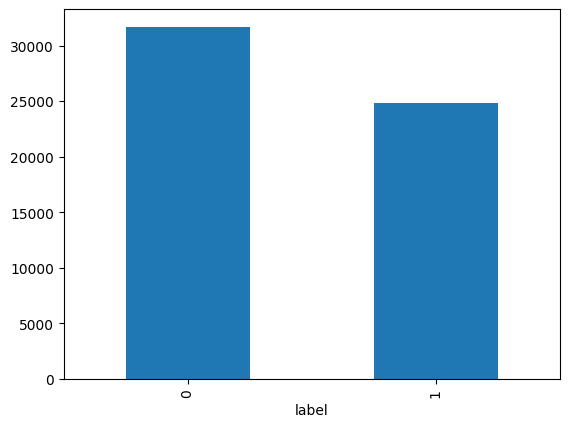

In [18]:
# balanceamento das classes binarias
pd.concat([y_train_bin , y_test_bin]).value_counts().plot(kind='bar')

In [19]:
# BALANCEAMENTO DAS CLASSES POR REDUCAO DA MAJORITARIA E EQUIVALENCIA DAS MENORES
# Instanciar undersampler
under =  RandomUnderSampler(random_state=42,sampling_strategy='not minority')
X_train_u, y_train_u = under.fit_resample(xX_train,yy_train)


In [20]:
X_train_u.columns

Index(['cod_especie', 'recorrencia_em_lotes_anteriores', 'resposta_pergunta',
       'anexou_arquivo', 'despacho_sub', 'motivo_sub',
       'correlacao_motivo_recurso_sub', 'ddb', 'dat', 'der_sub',
       'data_evento_gerador', 'requerimento_recurso',
       'situacao_sub_simplificada', 'comp_situacao'],
      dtype='object')

<Axes: xlabel='label'>

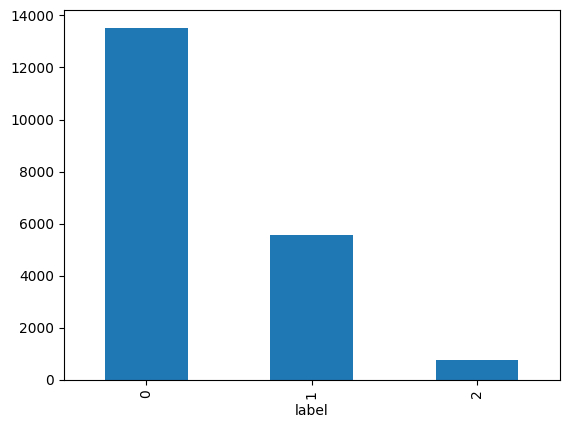

In [21]:
# Checagem Balanceamento das Cargas
yy_train.value_counts().plot(kind='bar')

<Axes: xlabel='label'>

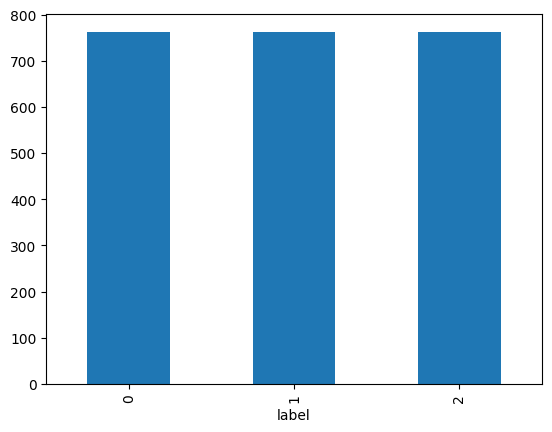

In [22]:
# Checagem de Balancemento de cargas pos tratamento
y_train_u.value_counts().plot(kind='bar')

## 3 - Ferramentas de *Processamento*

In [23]:
def plota_matriz_correlacao(dfxy: pd.DataFrame, dist=''):
  plt.figure(figsize=(6,4))
  corr_matrix = dfxy.corr().round(2)
  # Criar uma máscara para a parte superior da matriz de correlação, sem excluir a diagonal
  mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)  # k=1 mantém a diagonal
  fig, ax = plt.subplots(figsize=(20, 15))
  # Exibir a matriz de correlação com a diagonal visível
  sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', linewidths=0.5, ax=ax,vmin=-1, vmax=1)
  plt.title('Correlação entre Variáveis {dist} (Diagonal visível)'.format(dist=dist))
  plt.show()

In [24]:
from sklearn.inspection import permutation_importance
def apresenta_importancia(modelo,xtest,ytest, repeticao=10):
  # Calcular a importância das features por permutação
  importancia = permutation_importance(modelo, xtest, ytest, n_repeats=repeticao, random_state=42)
  # Obter as importâncias médias e o desvio padrão das importâncias
  importancias_medias = importancia.importances_mean
  importancias_desvio = importancia.importances_std
  features =  X_test.columns
  # Ordenar as importâncias em ordem decrescente
  indices = np.argsort(importancias_medias)[::-1]

  # Plotar a importância das features na horizontal com desvio padrão
  plt.figure(figsize=(10, 6))
  plt.title("Importância das Features por Permutação")
  plt.barh(range(len(importancias_medias)), importancias_medias[indices], xerr=importancias_desvio[indices], align="center", color='skyblue')
  plt.yticks(range(len(importancias_medias)), features[indices])
  plt.gca().invert_yaxis()  # Inverter o eixo Y para que a feature mais importante fique no topo
  plt.xlabel('Importância (por permutação)')
  plt.ylabel('Features')
  plt.tight_layout()
  plt.show()


In [25]:
def plota_matriz_confusao(modelo,ypred,ytest,title=''):
  #cm = confusion_matrix(ytest, ypred)
  print(title)
  labelss = modelo.classes_ if hasattr(modelo, 'classes_') else modelo
  cm = confusion_matrix(ytest, ypred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labelss)
  fig, ax = plt.subplots(figsize=(10, 10))  # Ajuste o figsize conforme necessário

  disp.plot(ax=ax)
  plt.show()

In [26]:
def apresenta_importancia_feature(modelo, dist=''):
  # Calcular a importância das features por permutação
  label_balanceadas = modelo.named_steps['preprocessor'].get_feature_names_out()
  label_balanceadas = [str(i).split('__')[1] if len(str(i).split('__')) > 1 else str(i) for i in label_balanceadas]
  # importancias desbalanceadas
  importancias = modelo.named_steps['classifier'].feature_importances_
  plt.bar(range(len(importancias)), importancias)
  plt.xticks(range(len(importancias)), label_balanceadas, rotation=90)
  plt.xlabel('Features')
  plt.ylabel('Importância')
  plt.title('Importância das Features '+ dist)
  plt.show()

## **4** - **Preparação dos Pipelines dos Modelo Binário e de Classificação sucessiva**

In [27]:
# criando a label dara as variaveis independentes pós encodamento via Onehotencoder e kbindiscret
nproc = preprocessor.fit_transform(X)
labell = [str(i).split('__')[1] if len(str(i).split('__')) > 1 else str(i) for i in preprocessor.get_feature_names_out()]

In [28]:
# Importacao de classes e modulos
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')

In [29]:
# criacao de pipelines com otimizacao oriunda de experimentos do grid search cv
# pipeline para classe 0 para avaliacao de duas classes sendo a 2 o escape
pipeline_bin = Pipeline([
    ('preprocessor', preprocessor),
  #  ('undersampler', under),
    ('classifier', XGBClassifier(objective='binary:hinge',
                                 min_child_weight= 1.3,
gamma = 0.3,
eta= 0.1,
n_estimators = 300,
max_depth = 8,
num_class=1,
random_state=42))
])

# pipeline para classes 1 para avaliacao de tres classes sendo a 2 e 3 o escape

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
  #  ('undersampler', under),
    ('classifier', XGBClassifier(objective='binary:hinge',
                                 min_child_weight= 1.3,
gamma = 0.3,
eta= 0.1,
n_estimators = 350,
max_depth = 6,
num_class=2,
random_state=42))
])

# pipeline para classes 2 e 3 para avaliacao de duas classes 2 e 3 finalizando o modelo

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
  #  ('undersampler', under),
    ('classifier', XGBClassifier(objective='binary:hinge',
                                 min_child_weight= 1.3,
gamma = 0.3,
eta= 0.025,
n_estimators = 400,
max_depth = 8,
num_class=2,
random_state=42))
])

## **5** - **Modelo Binário Para Classificacao da Classe 0**

#### GBM XGB Classifier

###5.1 Modelo treinado para clivagem de classe binária e avaliação

In [30]:
scores_bin = cross_val_score(pipeline_bin, X_train, y_train_bin, cv=5, scoring='f1_weighted',error_score='raise')
print('scores desbalanceados por validacao cruzada')
print(scores_bin)
print(scores_bin.mean())
# Treinar Modelos de forma tradicional
modelo_plano_bin = pipeline_bin.fit(X_train, y_train_bin)
y_pred_bin = modelo_plano_bin.predict(X_test)
probabilidades = modelo_plano_bin.predict_proba(X_test)

print('f1 score desbalanceado')
print(f1_score(y_test_bin, y_pred_bin, average='weighted'))

print('relatorio de classificacao de classes desbalanceadas')
print(classification_report(y_test_bin, y_pred_bin))
# analise de retorno e importancia de variaveis com azo de redistribuicao de features
teste_prob = [(i,[dic_label[ki] + ' prob: ' + str(ii) for ki,ii in enumerate(probabilidades[k])]) for k,i in enumerate(y_pred_bin) if probabilidades[k][0] not in [0.0,1.0]]
print("valores de probabilidade por classe prevista")
#print(teste_prob)

importancias_bin = modelo_plano_bin.named_steps['classifier'].feature_importances_


scores desbalanceados por validacao cruzada
[0.97876806 0.9798817  0.97976416 0.98053852 0.98042546]
0.9798755804968902
f1 score desbalanceado
0.9830193685327673
relatorio de classificacao de classes desbalanceadas
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      6340
           1       0.98      0.98      0.98      4967

    accuracy                           0.98     11307
   macro avg       0.98      0.98      0.98     11307
weighted avg       0.98      0.98      0.98     11307

valores de probabilidade por classe prevista


###5.1.1 Graficos de importancia de *features*

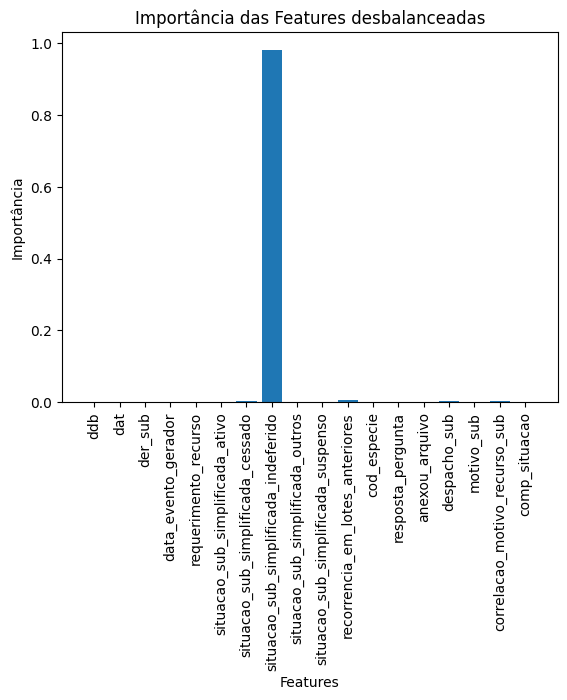

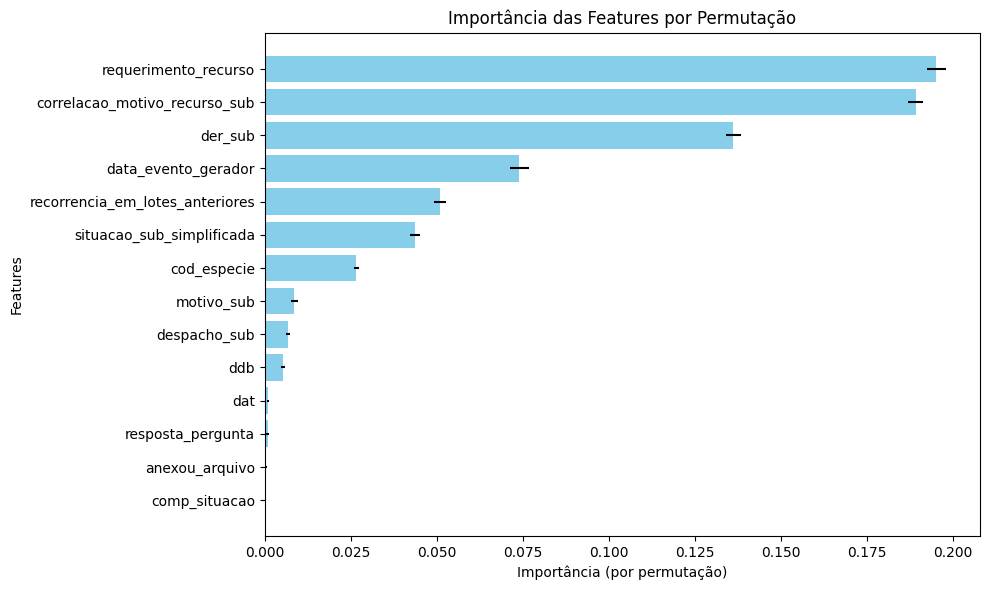

{'anexou_arquivo': 0.00015744791,
 'cod_especie': 0.0011977783,
 'comp_situacao': 0.00019839795,
 'correlacao_motivo_recurso_sub': 0.0040988144,
 'dat': 0.00027001573,
 'data_evento_gerador': 0.0012296946,
 'ddb': 0.00025361613,
 'der_sub': 0.00040862942,
 'despacho_sub': 0.0016656198,
 'motivo_sub': 0.0011791845,
 'recorrencia_em_lotes_anteriores': 0.004889678,
 'requerimento_recurso': 0.00068879,
 'resposta_pergunta': 0.00013483367,
 'situacao_sub_simplificada_ativo': 0.0002464703,
 'situacao_sub_simplificada_cessado': 0.0020200182,
 'situacao_sub_simplificada_indeferido': 0.9811074,
 'situacao_sub_simplificada_outros': 7.0747265e-05,
 'situacao_sub_simplificada_suspenso': 0.00018275707}


In [31]:
apresenta_importancia_feature(modelo_plano_bin, dist='desbalanceadas')
# importancia por permutacao desbalanceado
apresenta_importancia(modelo_plano_bin,X_test,y_test_bin)
pprint(dict(zip(labell, importancias_bin)))

###5.1.2 Matriz de confusão

MATRIZ DE CONFUSAO CLIVAGEM BINARIA


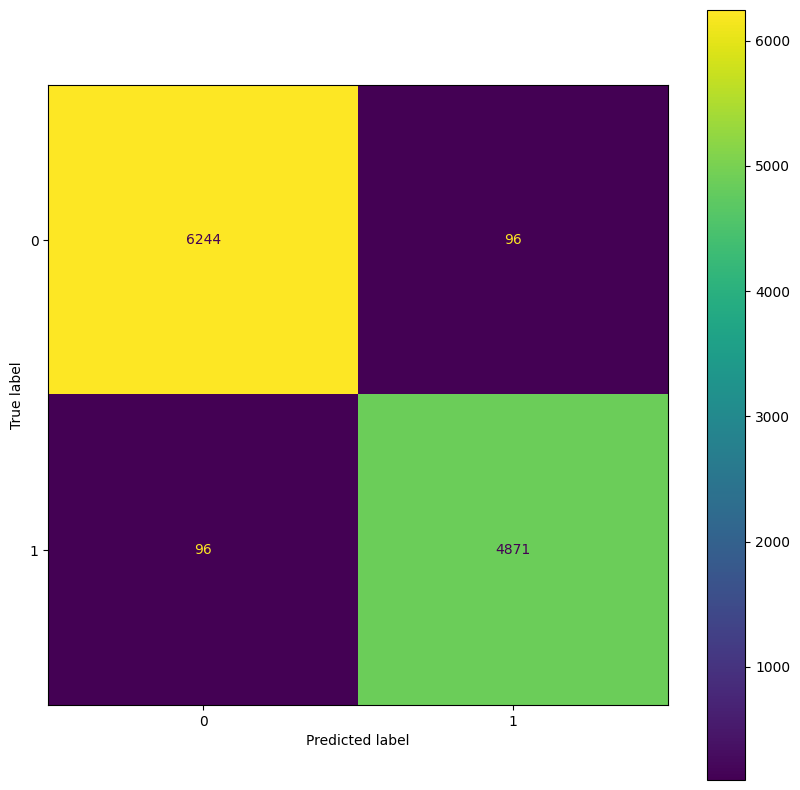

In [32]:
plota_matriz_confusao(modelo_plano_bin,y_pred_bin,y_test_bin, 'MATRIZ DE CONFUSAO CLIVAGEM BINARIA')

## **6** - **Modelo Binário intermediario Para Classificacao da Classe 1**

In [33]:
scores_1 = cross_val_score(pipeline_1 , xX_train, yy_train, cv=5, scoring='f1_weighted',error_score='raise')
print('scores desbalanceados por validacao cruzada')
print(scores_1)
print(scores_1.mean())
# Treinar Modelos de forma tradicional
modelo_plano_1 = pipeline_1.fit(xX_train, yy_train)
y_pred_1 = modelo_plano_1.predict(xX_test)
probabilidades1 = modelo_plano_1.predict_proba(xX_test)

print('f1 score desbalanceado')
print(f1_score(yy_test, y_pred_1, average='weighted'))

print('relatorio de classificacao de classes desbalanceadas')
print(classification_report(yy_test, y_pred_1))
# analise de retorno e importancia de variaveis com azo de redistribuicao de features
teste_prob = [(i,[dict_label_transform_retificado[ki] + ' prob: ' + str(ii) for ki,ii in enumerate(probabilidades[k])]) for k,i in enumerate(y_pred_1) if probabilidades[k][0] not in [0.0,1.0]]
print("valores de probabilidade por classe prevista")
#print(teste_prob)

importancias_1 = modelo_plano_1.named_steps['classifier'].feature_importances_


scores desbalanceados por validacao cruzada
[0.93405184 0.93052554 0.93444639 0.92917154 0.93038168]
0.9317153956533835
f1 score desbalanceado
0.9310081816904303
relatorio de classificacao de classes desbalanceadas
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3381
           1       0.91      0.88      0.89      1396
           2       0.66      0.44      0.53       190

    accuracy                           0.93      4967
   macro avg       0.84      0.77      0.80      4967
weighted avg       0.93      0.93      0.93      4967

valores de probabilidade por classe prevista


###6.1 Matriz de confusão

MATRIZ DE CONFUSAO CLIVAGEM BINARIA CONFIRMACAO


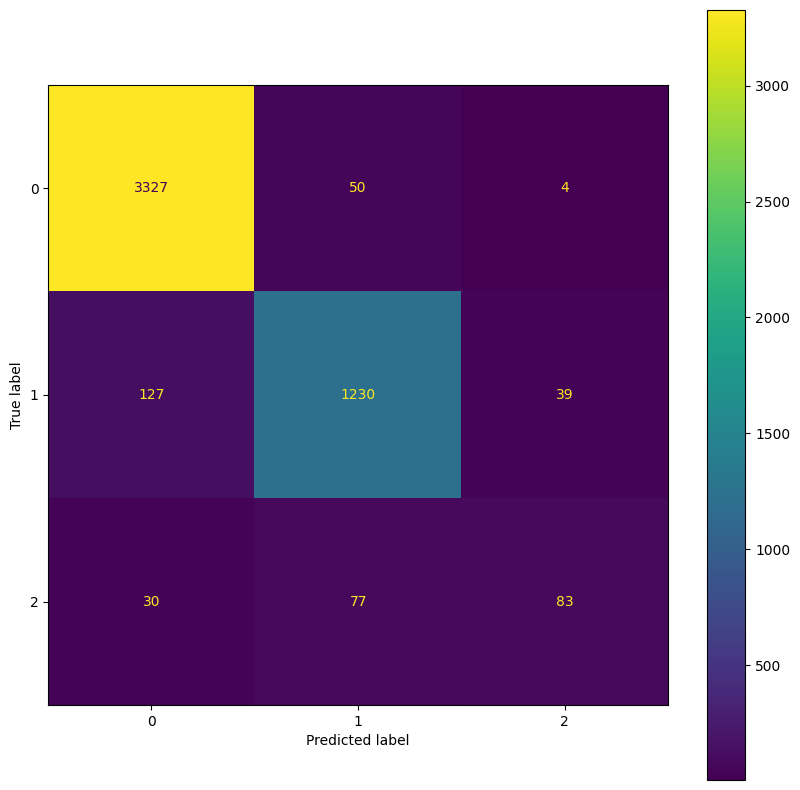

In [34]:
plota_matriz_confusao(modelo_plano_1,y_pred_1,yy_test, 'MATRIZ DE CONFUSAO CLIVAGEM BINARIA CONFIRMACAO')

## **7** - **Modelo Binário intermediario Para Classificacao da Classe 2 e 3**

In [35]:
scores_2 = cross_val_score(pipeline_2 , X_train_u, y_train_u, cv=5, scoring='f1_weighted',error_score='raise')
print('scores desbalanceados por validacao cruzada')
print(scores_2)
print(scores_2.mean())
# Treinar Modelos de forma tradicional
modelo_plano_2 = pipeline_2.fit(X_train_u, y_train_u)
y_pred_2 = modelo_plano_2.predict(xX_test[y_pred_1 !=0])
probabilidades2 = modelo_plano_2.predict_proba(xX_test[y_pred_1 !=0])

print('f1 score desbalanceado')
print(f1_score(yy_test[y_pred_1 !=0], y_pred_2, average='weighted'))

print('relatorio de classificacao de classes desbalanceadas')
print(classification_report(yy_test[y_pred_1 !=0], y_pred_2))
# analise de retorno e importancia de variaveis com azo de redistribuicao de features
teste_prob = [(i,[dict_label_transform_retificado[ki] + ' prob: ' + str(ii) for ki,ii in enumerate(probabilidades[k])]) for k,i in enumerate(y_pred_2) if probabilidades[k][0] not in [0.0,1.0]]
print("valores de probabilidade por classe prevista")
#print(teste_prob)

importancias_2 = modelo_plano_2.named_steps['classifier'].feature_importances_

scores desbalanceados por validacao cruzada
[0.79124454 0.7807021  0.84959978 0.78760934 0.80914388]
0.8036599300652106
f1 score desbalanceado
0.7955830300726475
relatorio de classificacao de classes desbalanceadas
              precision    recall  f1-score   support

           0       0.32      0.13      0.18        54
           1       0.93      0.81      0.86      1269
           2       0.33      0.75      0.46       160

    accuracy                           0.77      1483
   macro avg       0.53      0.56      0.50      1483
weighted avg       0.84      0.77      0.80      1483

valores de probabilidade por classe prevista


###7.1 Matriz de confusão

MATRIZ DE CONFUSAO CLIVAGEM BINARIA CONFIRMACAO


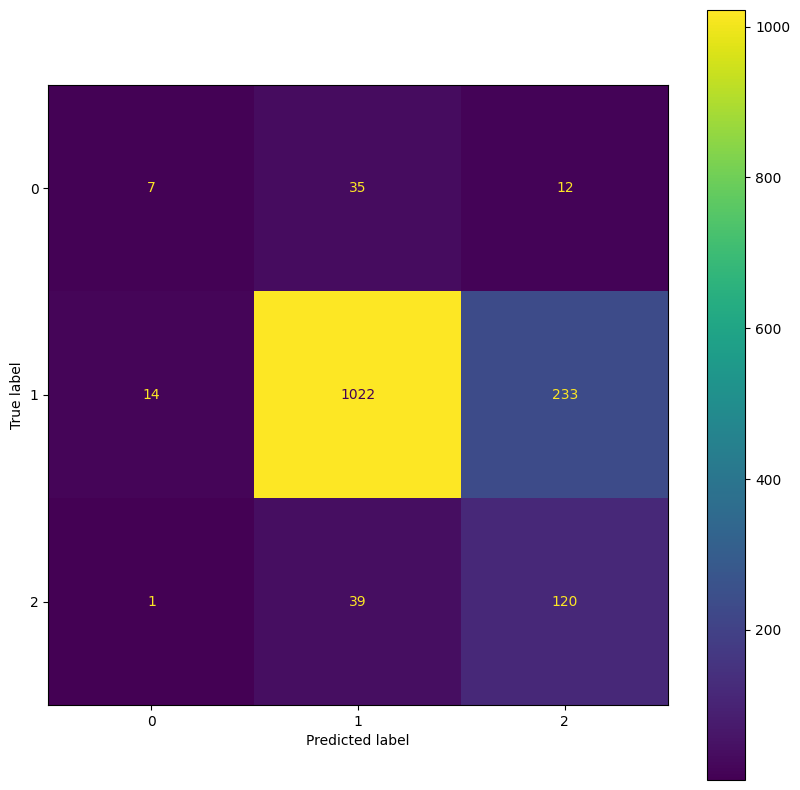

In [36]:
plota_matriz_confusao(modelo_plano_2,y_pred_2,yy_test[y_pred_1 !=0], 'MATRIZ DE CONFUSAO CLIVAGEM BINARIA CONFIRMACAO')

###8 **Conclusao modelos**

In [37]:
X_train_u.shape

(2289, 14)

In [38]:

print("binario")
print("SHAPE", X_train.shape)
print("F1 Score(macro):", f1_score(y_test_bin,y_pred_bin, average='macro' ))
print("F1 Score:(weighted)", f1_score(y_test_bin,y_pred_bin, average='weighted' ))
print("F1 Score:(micro)", f1_score(y_test_bin,y_pred_bin, average='micro' ))

print("Modelo Intermediário")
print("SHAPE", xX_train.shape)
print("F1 Score(macro):", f1_score(yy_test,y_pred_1, average='macro' ))
print("F1 Score:(weighted)", f1_score(yy_test,y_pred_1, average='weighted' ))
print("F1 Score:(micro)", f1_score(yy_test,y_pred_1, average='micro' ))

print("Modelo Final")
print("SHAPE", X_train_u.shape)
print("F1 Score(macro):", f1_score(yy_test[y_pred_1 !=0],y_pred_2, average='macro' ))
print("F1 Score:(weighted)", f1_score(yy_test[y_pred_1 !=0],y_pred_2, average='weighted' ))
print("F1 Score:(micro)", f1_score(yy_test[y_pred_1 !=0],y_pred_2, average='micro' ))

binario
SHAPE (45228, 14)
F1 Score(macro): 0.9827652411277206
F1 Score:(weighted) 0.9830193685327673
F1 Score:(micro) 0.9830193685327673
Modelo Intermediário
SHAPE (19868, 14)
F1 Score(macro): 0.7960504968184479
F1 Score:(weighted) 0.9310081816904303
F1 Score:(micro) 0.9341654922488424
Modelo Final
SHAPE (2289, 14)
F1 Score(macro): 0.5018746655221563
F1 Score:(weighted) 0.7955830300726475
F1 Score:(micro) 0.7747808496291302


##8.1 **Matrizes de Confusao**

MATRIZ DE CONFUSAO MODELO BINARIO


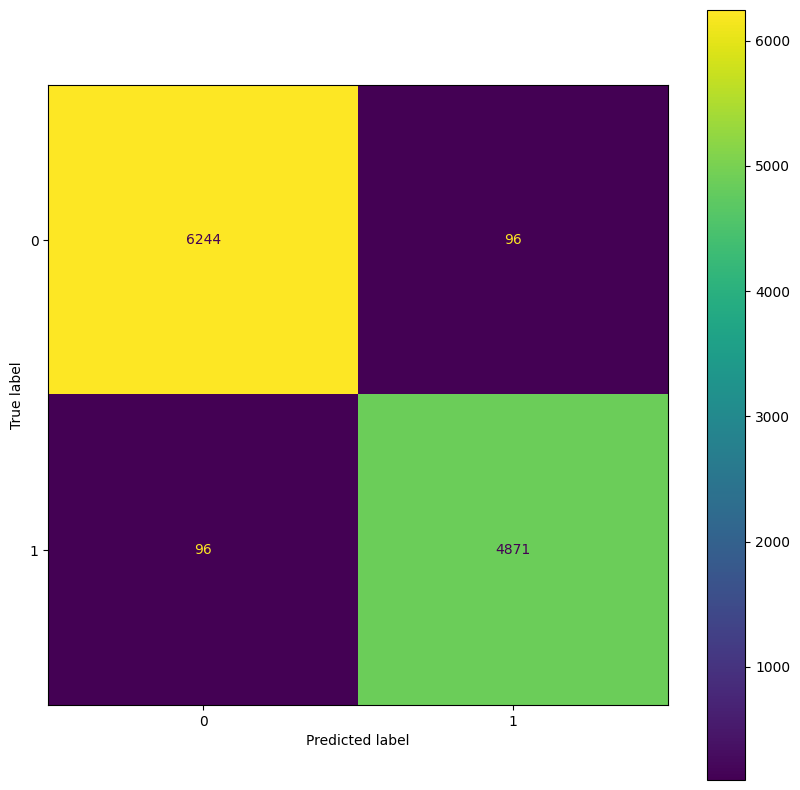

In [39]:
plota_matriz_confusao(modelo_plano_bin,y_pred_bin,y_test_bin, 'MATRIZ DE CONFUSAO MODELO BINARIO')

MATRIZ DE CONFUSAO MODELO INTERMEDIARIO


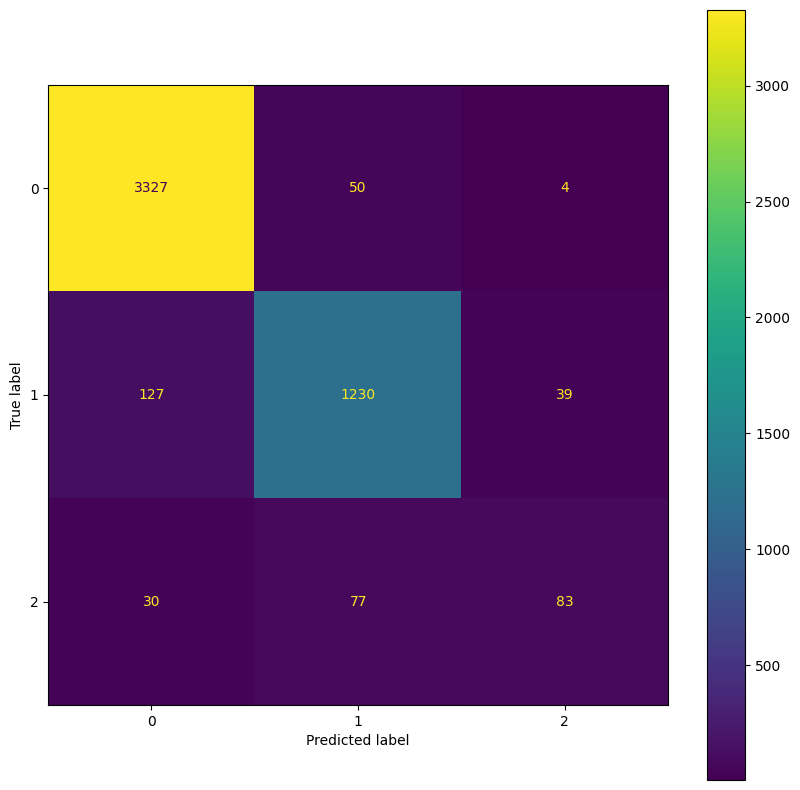

In [40]:
plota_matriz_confusao(modelo_plano_1,y_pred_1,yy_test, 'MATRIZ DE CONFUSAO MODELO INTERMEDIARIO')

In [41]:
#plota_matriz_confusao(modelo_plano_2,y_pred_2,yy_test, 'MATRIZ DE CONFUSAO MODELO FINAL')

##9 **Conclusao Modelos Encadeados**

In [62]:
lista_4_classes = ['automatizavel sem problemas', 'necessaria analise por servidor',
             'necessario envio para definicao politica', 'necessario envio para grupo especializado']
dict_4_classes = {k:v for k,v in enumerate(lista_4_classes)}

###9.1 **Modelo Entrada**

In [43]:
#Retreina o modelo binario para driblar o bug do modelo treinado anterior
modelo_plano_bin1 = pipeline_bin.fit(X_train, y_train_bin)
y_pred_inicio =modelo_plano_bin1.predict(X_test)

MATRIZ DE CONFUSAO MODELO BINARIO


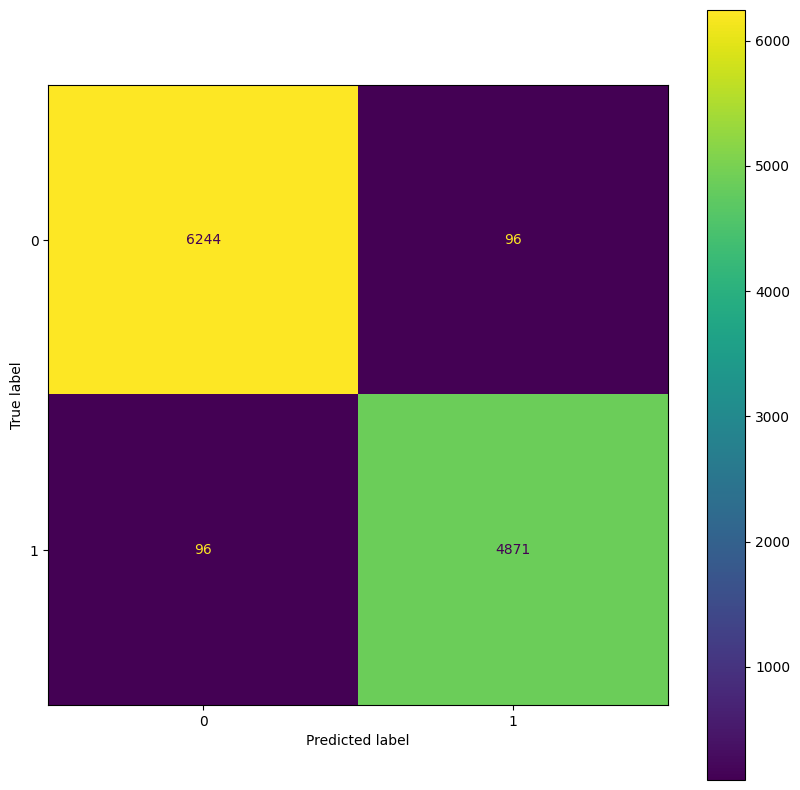

In [44]:
#Matriz de Confusão Binária apenas separação
plota_matriz_confusao(modelo_plano_bin1,y_pred_inicio,y_test.replace([1,2,3],1), 'MATRIZ DE CONFUSAO MODELO BINARIO')

In [45]:
#Preparacao para fluxo de devolucao do y consolidado ( concatenação de previsões )
X_test_inicio_retificado = X_test[y_pred_inicio==0]
y_pred_inicio_retificado = pd.Series(y_pred_inicio[y_pred_inicio==0],index=X_test_inicio_retificado.index)

MATRIZ DE CONFUSAO MODELO BINARIO


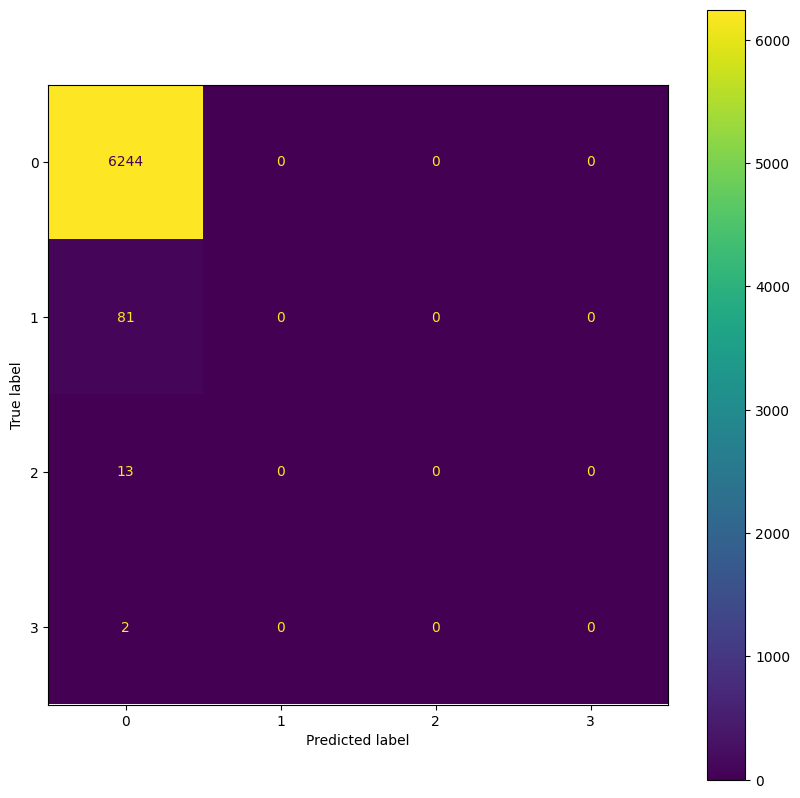

In [46]:
#Matriz de Confusão Binária da Classe Especializada ( 0 ) em relação as outras classes
plota_matriz_confusao([0,1,2,3],y_pred_inicio_retificado,y_test[X_test_inicio_retificado.index], 'MATRIZ DE CONFUSAO MODELO BINARIO')

In [47]:
#joblib.dump(modelo_plano_bin1, 'entrada.pkl')
print("Modelo GBM salvo como 'entrada.pkl'")

Modelo GBM salvo como 'entrada.pkl'


###9.2 **Modelo Intermediário**

In [48]:
#Retreino do modelo Secundário
modelo_plano_11 = pipeline_1.fit(xX_train, yy_train)
#Corta o X usando apenas a parte que foi prevista pelo modelo binário como 1
X_test_medio = X_test[y_pred_inicio ==1]
y_pred_medio = modelo_plano_11.predict(X_test_medio)
yy_test = y_test[y_pred_inicio ==1]
y_falhas = y_test[(y_pred_inicio ==1) & (y_test ==0)]
y_test_intermediario =yy_test

MATRIZ DE CONFUSAO MODELO INTERMEDIARIO


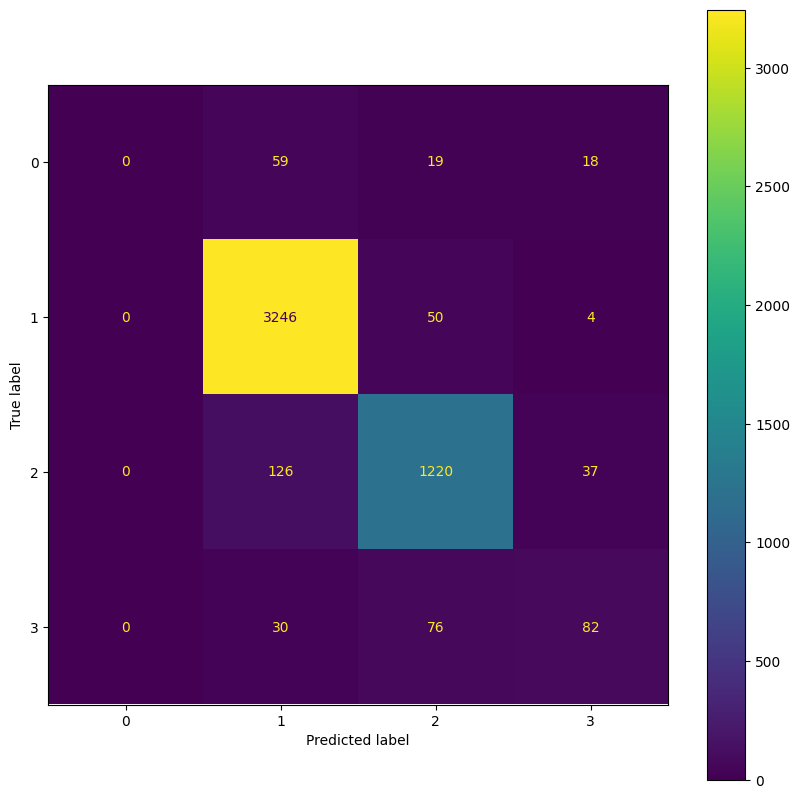

In [49]:
#Matriz de Confusão Três classes referente apenas ao que foi passado pelo modelo binário
plota_matriz_confusao([0,1,2,3],y_pred_medio +1,y_test_intermediario , 'MATRIZ DE CONFUSAO MODELO INTERMEDIARIO')

In [50]:
#Preparacao para fluxo de devolucao do y consolidado ( concatenação de previsões )
X_test_medio_retificado = X_test_medio[y_pred_medio == 0]
y_pred_medio_retificado = pd.Series(y_pred_medio[y_pred_medio == 0],index=X_test_medio_retificado.index)
# a soma do numero 1 serve para alinhar o modelo de 3 classes ao de quatro sendo o de tres classes treinado com as classes 1,2,3 e colocadas com 0,1,2
y_pred_medio_retificado = y_pred_medio_retificado + 1

MATRIZ DE CONFUSAO MODELO INTERMEDIARIO


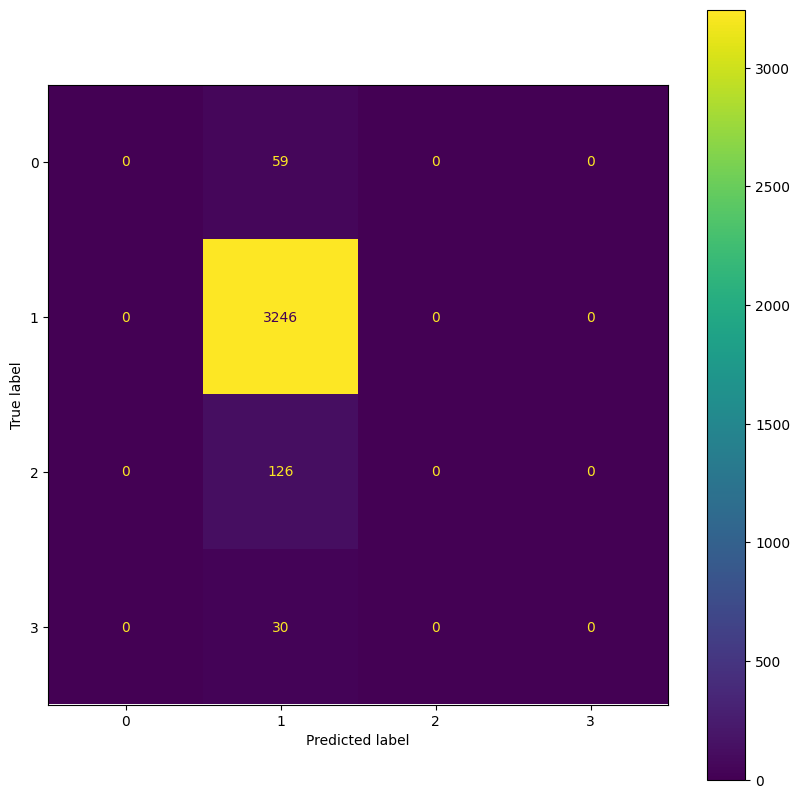

In [51]:
#Matriz de Confusão para classe especializada
plota_matriz_confusao([0,1,2,3],y_pred_medio_retificado,y_test[y_pred_medio_retificado.index] , 'MATRIZ DE CONFUSAO MODELO INTERMEDIARIO')

In [52]:
#joblib.dump(modelo_plano_1, 'intermediario.pkl')
print("Modelo GBM salvo como 'intermediario.pkl'")

Modelo GBM salvo como 'intermediario.pkl'


###9.3 **Modelo Final**

In [53]:
#Retreino do modelo Terciário
modelo_plano_21 = pipeline_2.fit(X_train_u, y_train_u)
#Corta o X à partir do predito no anterior tirando a classe especializada do modelo anterior
X_test_final = X_test_medio[y_pred_medio !=0]
y_pred_final = modelo_plano_21.predict(X_test_final)
yyy_test = yy_test[y_pred_medio !=0]

MATRIZ DE CONFUSAO MODELO FINAL


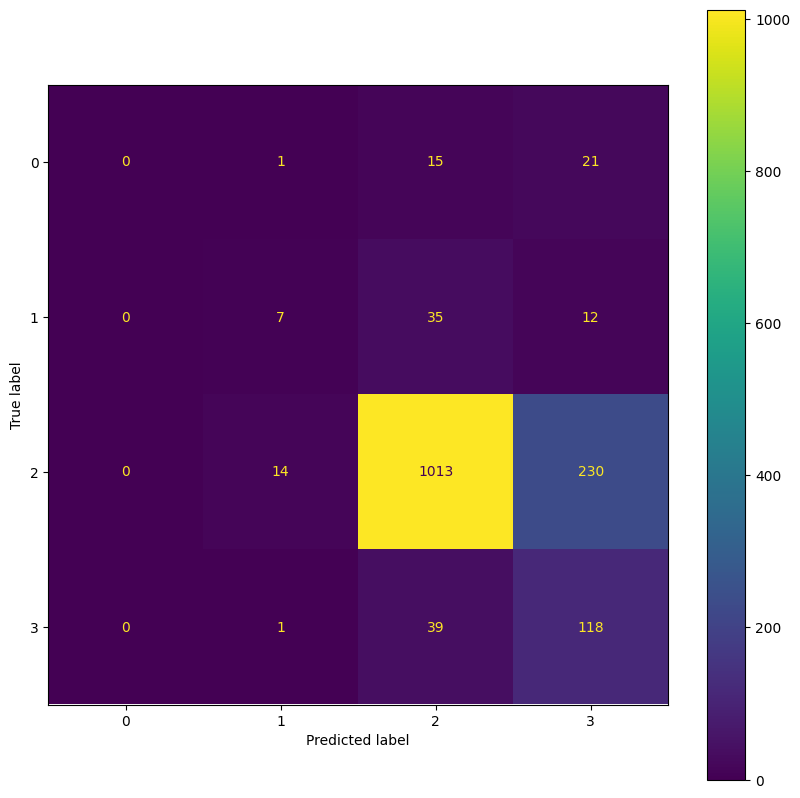

In [54]:
#Matriz de Confusão Três classes referente apenas ao que foi passado pelo modelo anterior
plota_matriz_confusao([0,1,2,3],y_pred_final +1,yyy_test, 'MATRIZ DE CONFUSAO MODELO FINAL')

In [55]:
#Preparacao para fluxo de devolucao do y consolidado ( concatenação de previsões )
y_pred_final_retificado = pd.Series(y_pred_final,index=X_test_final.index)
X_test_final_retificado = X_test_final
y_pred_final_retificado = y_pred_final_retificado + 1

MATRIZ DE CONFUSAO MODELO FINAL


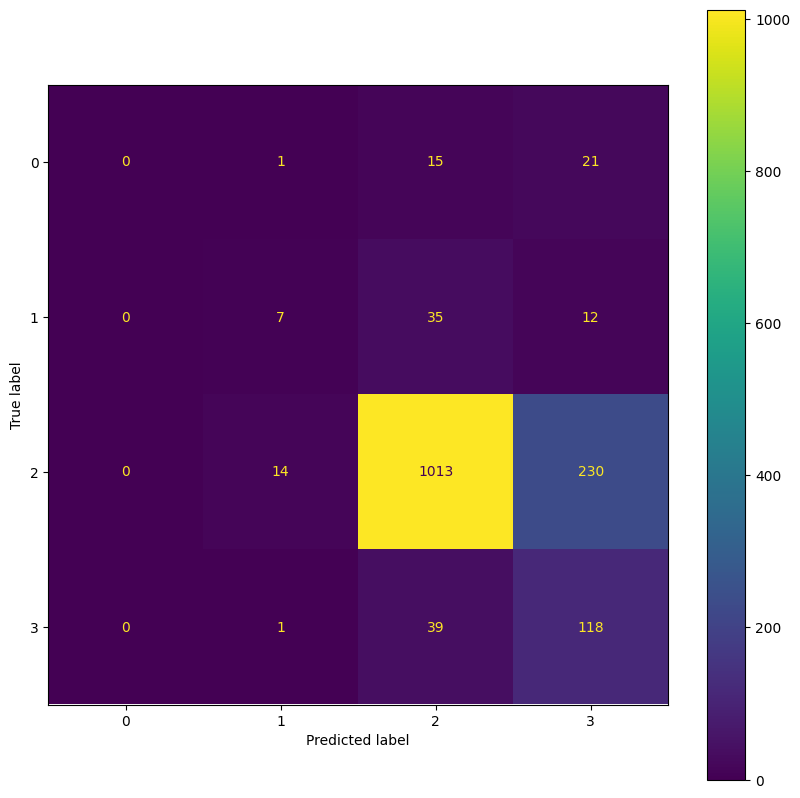

In [56]:
#Matriz de Confusão para classe especializada
plota_matriz_confusao([0,1,2,3],y_pred_final_retificado,y_test[y_pred_final_retificado.index], 'MATRIZ DE CONFUSAO MODELO FINAL')

In [57]:
#joblib.dump(modelo_plano_2, 'final.pkl')
print("Modelo GBM salvo como 'final.pkl'")

Modelo GBM salvo como 'final.pkl'


###9.4 **Matriz de Confusão Consolidada dos Modelos Encadeados**

In [58]:
#Consolidando os y's previstos nos tres modelos
y_pred_consolidado = pd.concat([y_pred_inicio_retificado,y_pred_medio_retificado,y_pred_final_retificado])
#Necessário usar o sort para que a matriz de Confusão nao apresente erro
y_pred_consolidado = y_pred_consolidado.sort_index()
y_test = y_test.sort_index()

In [63]:
y_pred_consolidado1 = y_pred_consolidado.replace(dict_4_classes)
y_test1 = y_test.replace(dict_4_classes)

MATRIZ DE CONFUSAO MODELO CONSOLIDADA


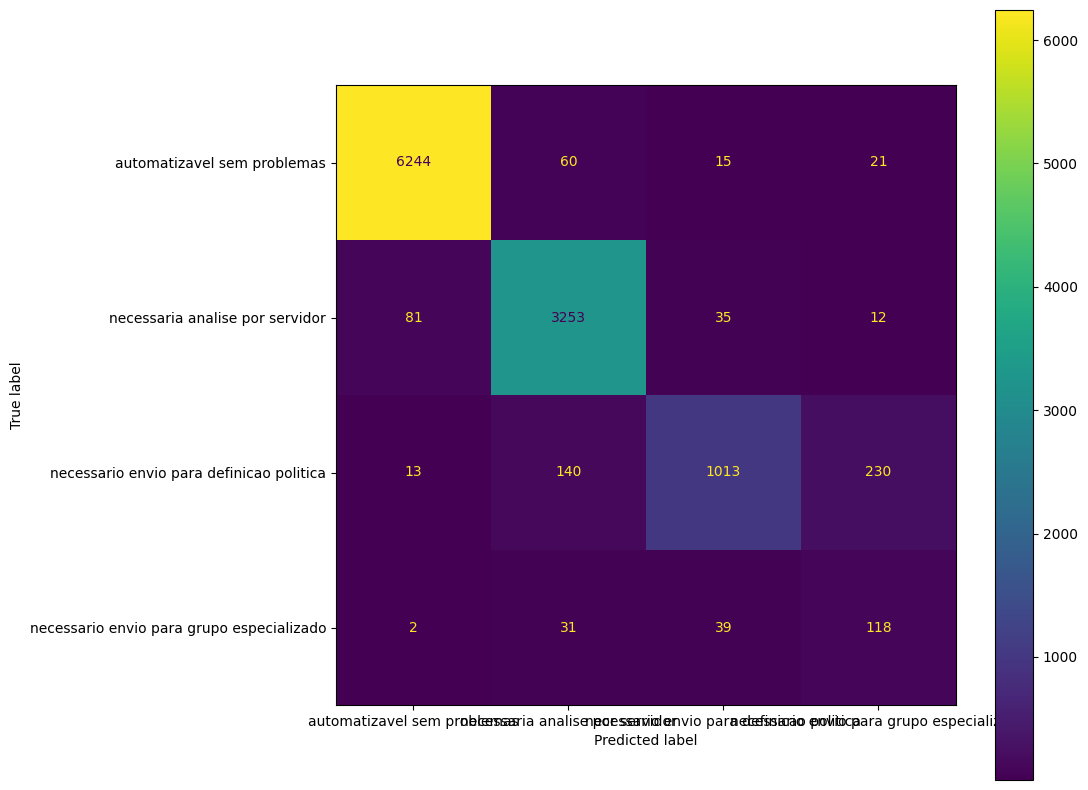

In [64]:
#MATRIZ DE CONFUSAO CONSOLIDADA
plota_matriz_confusao(list(dict_4_classes.values()),y_pred_consolidado1,y_test1, 'MATRIZ DE CONFUSAO MODELO CONSOLIDADA')

###9.5 **f1_score Consolidado dos Modelos Encadeados**

In [66]:
print("F1 Score(weighted):",f1_score(y_test, y_pred_consolidado, average='weighted'))
print("F1 Score(macro):",f1_score(y_test, y_pred_consolidado, average='macro'))
print("F1 Score(micro):",f1_score(y_test, y_pred_consolidado, average='micro'))

F1 Score(weighted): 0.942685613309813
F1 Score(macro): 0.7892306548864759
F1 Score(micro): 0.9399487043424427
